# MMN 11 - Roman Waitzman (313597270)

In this assignment I will implament a Multi-Class Perceptron with a Pocket algorithm, and attempt to classify the digits in the MNIST dataset.

This will be done in two steps:
1. Implament a Binary Classification Perceptron (independant from the multicalss perceptron) that will receive a class on initialization, whose performance we will analyize for some chosen class (for example '1' vs 'not 1').
2. Extend this to the Multi-Class Perceptron, which will implament a one-vs-all strategy using the Binary Classification Perceptron created in part 1, building off of the analysis in part 1 and extending it.

And in addition, an overview of the performance in the end of the notebook.

### Imports

In [ ]:
%pip install numpy pandas seaborn matplotlib scikit-learn tabulate

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from types import SimpleNamespace
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
np.seterr(divide='ignore')

### Cleaning the dataset

I will first import the dataset, and clean the data to a form appropriate for use with the perceptron model.

Each feature vector, which have 784 elements (a flattened 28*28 image) in the dataset will have a bias with the value 1 added to the beginning of the vector, meaning each feature vector is now of size 785.

The classes will be one-hot encoded as a vector of size 10 (the number of classes in the MNIST dataset) with every element in the vecotr being zero and the elementh in $ith$ place being 1, with $i$ corresponding to the numeric value of the class.
For example: $one-hot('5') = (0,0,0,0,0,1,0,0,0,0)$

In [12]:
# Access features (pixel values) and labels
X, y = mnist['data'], mnist['target']
classes = sorted(list(y.unique()))
n_classes = int(y.to_numpy().max()) + 1

# one hot encode labels
y = y.astype(int)
values = y.astype('int').to_list()
one_hot_classes = np.eye(n_classes, dtype='int')
one_hot_y = one_hot_classes[values]

# adding bias to dataset
X_biased = X.copy()
X_biased.insert(0, 'pixel0', 1)
X_proper = X_biased.to_numpy()

I will now use the train_test_split method supplied by sklearn to divide the dataset into training and testing sets.

The MNIST dataset has $70,000$ images, and as required by the outline of the assignment, the training set will be of size $60,000$ ($\frac{6}{7}th$ of the dataset), and the testing set will be of size $10,000$ ($\frac{1}{7}th$ of the dataset.

The sets will be stratified using the labels, to have a balanced representation of classes in our training and testing sets.


In [13]:
# create test and train split
X_train, X_test, y_train, y_test = train_test_split(
    X_proper, one_hot_y, test_size=1/7,
    shuffle=True, stratify=one_hot_y, random_state=0
)

## Binary Perceptron with Pocket algorithm

As stated previously, we will begin with the binary perceptron, and give an overview of the implementation.

#### Overview of the implemntation of the fitting algorithm:
Our initial weight vector will be $\underline{w}_0 = \underline{0}$.

The basic idea of the perceptron algorithm is that given a column weight-vector $\underline{w}$ and a column feature vector $\underline{d}$, the label prediction will be $sign(\underline{w}^T * \underline{d})$ (the output of the inner product will of course be a scalar).

Now, for the sake of computation, I will rewrite this a bit to speed up the computation in numpy thusly:

for a given dataset $\textbf{D}$, where each row $i$ is a feature vector $\underline{d}_i$, and for the aforemention weight **column-vector** $\underline{w}$, the output of the product $\textbf{D} * \underline{w}$ is a column vector of the inner products of each row with $\underline{w}$, using numpy I can apply the vectorized $sign$ to receive a vector of signs $\underline{p}$, each representing the "activation" of a row from the dataset.

I can then compare our binary prediction vector $\underline{p}$ with our one-hot label matrix $\textbf{L}$ in the following manner:

For a given class that the perceptron is trying to learn to identify $\underline{c}$ (represented as a one-hot row vector), each row of the product $\textbf{L}*\underline{c}^T$, can be either the class vector or a zero vector. The product is then manipulated such that a new vector $\underline{l}'$ is created tagging each corresponding row with 1 for class and -1 for zeros.
Finally both vectors can be compared element wise to find the mismatches and consequantially the $E_{in}$.

The MNIST dataset, like many others, is not linearly seperable. As a result I will implament a Pocket algorithm as part of the perceptron. This means it will also receive the number of iterations we wish this algorithm to run for as a parameter in the fitting.

The Pocket will keep a memory of the perceptron fitting history, and will update each time a weight vector with better performance is found, estimated using the standard error evaluation method for the perceptron $E_{in} = \frac{1}{N} \sum_{t=1}^{N}[y_t\neq h_t]$, for $y_t$ as the label, and $h_t$ as the prediction, for feature-vector $\underline{d}_t$. We will use this measurement as the "loss" function in our analysis.

In accordance with the PLA algorithm, to update the weights I will pick a random misclassified feature vector $\underline{d}_k$, and update the weight vector to be $\underline{w}_{t+1} = \underline{w}_{t} + y_k*\underline{d}_k$ for iteration $t$ and the label of $\underline{d}_k$ being $y_k$.

A small caveat in the implamentation is that I would need to lookup a misclassified vector, and then find its label. Because I already have the predictions and the missclassification at hand, I can just as easily use $-h_k$, meaning the negative of the prediction of $\underline{d}_k$, instead of $y_k$, in this algorithm, as these labels are binary, and if there is a misclassification, than the original label will always be the complimantry of the predicted label, and such it will use $\underline{w}_{t+1} = \underline{w}_{t} - h_k*\underline{d}_k$ instead.

The fitting will continue to the next iteration to continue the process above untill we've reached the last epoch.

#### Overview of the implementation of the scoring method
The scoring method will receive a dataset and labels, and attempt to predict the dataset.

I will then compare the labels and the predictions element wise, crating a confusion matrix for each combination (true label and true prediction, true label and false prediction and so on).

after that I will calculate the accuracy, sensitivity and selectivity and output all four calculations, using the equations given in the assignment:

- The Accuracy is defined as ACC=(TP+TN)/(TP+TN+FP+FN)
- The sensitivity (True positive rate) is defined as TPR = TP/(TP+FN)
- The selectivity (True negative rate) is defined as TNR = TN/(TN+FP)

#### Other useful information about the model implamentation
The model will also have the following option:
- A validation set & labels can be passed to calulate loss independantly for model analysis.
- The model has an optional cut off value, that will allow it to stop iteration early if achieved.
- The model will have user friendly (albeit a bit a spammy) output messages during the fitting describing each epoch, that can be turned on and off if needed.

#### Class definition for the Perceptron

In [141]:
class Perceptron:
    """
    This class represents a binary classification perceptron,
    seeing as this perceptron is part of a multi-class classification
    algorithm, it will receive the class it is supposed to attempt to classify
    as a parameter on initialization.
    """
    def __init__(self, clas):
      """
      :param clas: clas to attempt to classify among multiple classes,
        in one-hot vector representation.
      """
      self._clas = clas
      self._best_weight_mem = SimpleNamespace(
          weight=None, train_loss=1, epochs=0)
      self._history = None

    # getters & setters #
    @property
    def history(self):
      return self._history

    @property
    def weight_memory(self):
      return self._best_weight_mem

    @weight_memory.setter
    def weight_memory(self, val):
      self._best_weight_mem.epoch = val[0]
      self._best_weight_mem.weight = val[1]
      self._best_weight_mem.train_loss = val[2]

    @property
    def clas(self):
      return self._clas

    # Fitting method and sub-methods #

    def fit(self, dataset, labels, epochs=580, validation=None, cut_off=None,
            verbose=True):
      """
      :param dataset: 2d array where each row is a feature vector
      :param labels: vector of labels where each value is a label for the
        corresponding row in the 'dataset'
      :param epochs: number of iterations for the pocket algorithm
        defualt is 580
      :param validation: a validaiton set that will be used to calulate a
        loss independant from the training set. This set will have no influence
        ove the training itself.
      :param cut_off: if a loss is found that is equal to or less than the
        cut off rate, the iteration will stop early.
      :param verbose: print out messages to user during fitting if True,
        default is True
      """
      # create history df if it doesn't exist
      if self._history is None:
        self._initialize_history(validation)

      # last_known_epoch used to keep correct epoch
      # enumeration in 'history' for multiple fits,
      # i.e. if fit is run more than once it should avoid the epoch
      # resetting in the middle of the history DataFrame
      last_known_epoch = self.history.iloc[-1]['epoch']

      # initial weight is the zero vector
      weight = np.zeros((len(dataset[0]), 1), dtype='int')

      # fit loop
      for epoch in range(1, epochs + 1):
        # create and evaluate prediction
        predictions = self._predict(dataset, weight)
        misclas = self._get_misclassified(predictions, labels)
        train_loss = self._loss(misclas)

        # perceptron validation
        if validation is not None:
          v_predictions = self._predict(validation[0], weight)
          v_misclas = self._get_misclassified(v_predictions, validation[1])
          validation_loss = self._loss(v_misclas)

        # pocket algorithm
        if self.weight_memory.train_loss > train_loss:
            self.weight_memory = epoch, weight, train_loss
            if validation is not None:
              pocket_validation_loss = validation_loss

        # cut-off rate for early exit
        if cut_off is not None and self.weight_memory.train_loss <= cut_off:
          break

        # interactive user update
        if verbose:
          self._update_user(epoch, train_loss)

        # PLA new weight
        X_mistakes, h_mistakes = dataset[misclas], predictions[misclas]
        choice = np.random.randint(len(h_mistakes))
        w_n = -1 * h_mistakes[choice] * X_mistakes[choice]
        weight += w_n.reshape(-1, 1)

        # update history
        if validation is not None:
          self._update_history(
            last_known_epoch, epoch, train_loss,
            validation_loss, pocket_validation_loss)
        else:
          self._update_history(last_known_epoch, epoch, train_loss)

      if verbose:
        print(f'best weight found in epoch: {self.weight_memory.epoch}')

    @staticmethod
    def _predict(dataset, weight):
      prediction = np.sign(dataset @ weight)
      prediction[prediction >= 0] = 1
      return prediction

    def _get_misclassified(self, h, labels):
      binary_labels = self._get_binary_labels(labels)
      misclassifies = h.T[0] != binary_labels
      return misclassifies

    @staticmethod
    def _loss(misclassified):
      return np.round(np.mean(misclassified), 5)

    def _get_binary_labels(self, labels):
      binary_labels = labels * self.clas
      binary_labels = binary_labels.any(axis=1)
      binary_labels = binary_labels.astype(int)
      binary_labels[binary_labels == 0] = -1
      return binary_labels

    def _update_user(self, epoch, train_loss):
      print(
        f"For epoch {epoch} on "
        f"perceptron-'{np.argmax(self.clas)}':")
      print(
        f"PLA train loss is {train_loss}, "
        f"Pocket train loss is {self.weight_memory.train_loss}")

    # fitting history methods #

    def _initialize_history(self, validation):
      columns = ['epoch', 'train_loss', 'pocket_train_loss']
      df_lsts = [[0, None, None]]
      if validation is not None:
        columns += ['validation_loss', 'pocket_validation_loss']
        df_lsts[0] += [None, None]
      self._history = pd.DataFrame(
          df_lsts,
          columns=columns)

    def _update_history(self, lk_epoch, epoch, train_loss,
                        validation_loss=None, pocket_validation_loss=None):
      n_ind = len(self._history)
      history_epoch = lk_epoch + int(epoch)
      row = [history_epoch, train_loss, self.weight_memory.train_loss]
      if validation_loss is not None:
        row += [validation_loss, pocket_validation_loss]
      self._history.loc[n_ind] = row

    # Scoring method and sub-methods #

    def score(self, dataset, labels):
      """
      :param dataset: 2d array where each row is a feature vector
      :param labels: vector of labels where each value is a label for the
        corresponding row in the 'dataset'
      """
      if self.weight_memory.weight is None:
        print("Model is unfitted, please run 'fit' method on dataset first")
        return

      # predict testing dataset and get binary labels
      predictions = self._predict(dataset, self.weight_memory.weight).T[0]
      self._retag_for_conf_mat(predictions)
      binary_labels = self._get_binary_labels(labels)
      self._retag_for_conf_mat(binary_labels)

      # create confusion matrix
      confusion_matrix = np.zeros((2, 2), dtype='int')
      for label, prediction in zip(binary_labels, predictions):
        confusion_matrix[label][prediction] += 1

      # calculate evaluations
      assessment = pd.DataFrame(
            columns=['accuracy', 'sensitivity', 'selectivity'])
      tp = confusion_matrix[0][0]
      tn = confusion_matrix[1][1]
      fn = confusion_matrix[0][1]
      fp = confusion_matrix[1][0]

      accuracy = np.round((tp + tn) / (tp + tn + fp + fn), 3)
      sensitivity = np.round(tp / (tp + fn), 3)
      selectivity = np.round(tn / (tn + fp), 3)
      assessment.loc[0] = [accuracy, sensitivity, selectivity]

      # return evaluations
      retval = SimpleNamespace(
        confusion_matrix=confusion_matrix, assessment=assessment
      )
      return retval

    @staticmethod
    def _retag_for_conf_mat(vec):
      vec[vec == 1] = 0
      vec[vec == -1] = 1

#### Training the model

I will chose a class to train on arbitrarly to benchmark the binary perceptron, for this example I will chose class '0'.

After some attempts, the optimal number of epochs for an **average** accuracy, sensitivity and selectivity of **95%+** is about **580 epochs**. The runtime for 580 epochs was measures to be roughly 1 minute on colab.

To cut off early, set 'cut_off' to acceptable loss ($E_{in}$) value for pocket algorithm to end model early. To avoid excessive messaging, change "verbose" to False to silence model printouts.

In [ ]:
epochs = 580
verbose = True
cut_off = None

p = Perceptron(clas=one_hot_classes[0])
p.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation=(X_test, y_test),
    cut_off=cut_off,
    verbose=verbose)

#### Assessing the Perceptron

In this graph I will plot the training loss and validation loss over each epoch in the model fitting process, both for the PLA and pocket algorithm in two separate graphs for ease of reading.

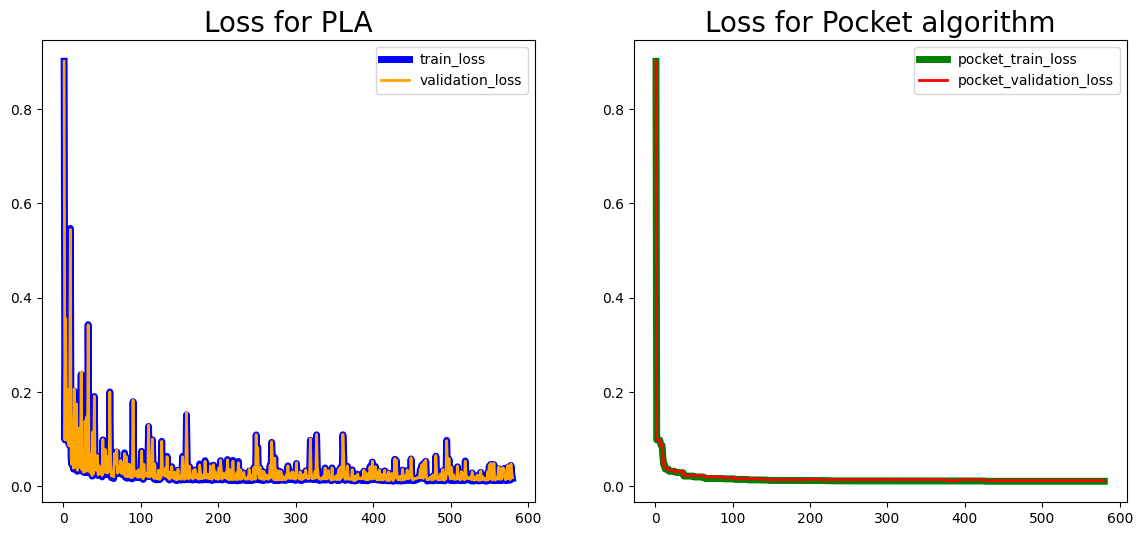

In [139]:
#fetch history for perceptron
history = p.history.dropna()
t = history['epoch']
tl = history['train_loss']
vl = history['validation_loss']
ptl = history['pocket_train_loss']
pvl = history['pocket_validation_loss']

# create graph
fig = plt.figure(figsize=(14, 6))
axs = fig.subplots(nrows=1, ncols=2)
font_size = 20

# plot PLA loss
axs[0].plot(t, tl, 'b', lw=5, label=history.columns[1])
axs[0].plot(t, vl, 'orange', lw=2 ,label=history.columns[3])
axs[0].set_title('Loss for PLA',  fontsize=font_size)
axs[0].legend()

# plot Pocket algorithm loss
axs[1].plot(t, ptl, 'g', lw=5, label=history.columns[2])
axs[1].plot(t, pvl, 'r', lw=2, label=history.columns[4])
axs[1].set_title('Loss for Pocket algorithm',  fontsize=font_size)
axs[1].legend()

plt.show()

#### Scoring the Perceptron

Let's score the test set to see how the model will do.

In [ ]:
# score test set
p_score = p.score(X_test, y_test)

Next, I will plot the confusion matrix given by the perceptron's 'score' method over a seaborn heatmap:

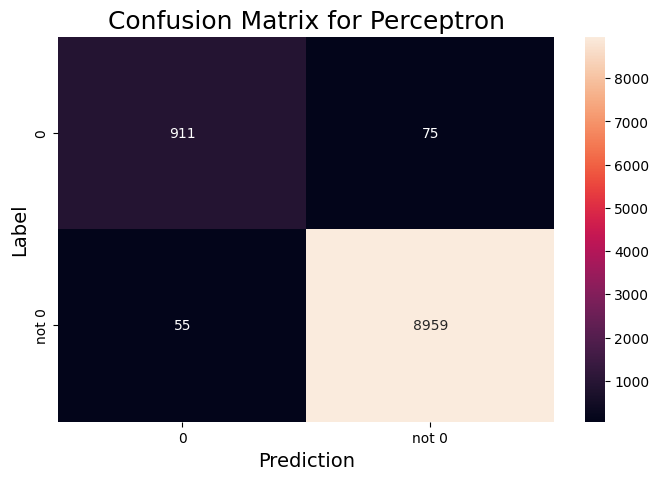

In [142]:
# fetch and arrange data to present in heatmap
clas = np.argmax(p.clas)
header = [clas, f'not {clas}']
heatmap_df = pd.DataFrame(
  p_score.confusion_matrix, index=header, columns=header)

# plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Perceptron', fontsize=18)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Label', fontsize=14)

plt.show()

Finally, I will plot the model's assessment in table:

In [126]:
headers= p_score.assessment.columns
table = tabulate(
  p_score.assessment, headers=headers, showindex=False, tablefmt="grid")
print(table)

+------------+---------------+---------------+
|   accuracy |   sensitivity |   selectivity |
+============+===============+===============+
|      0.987 |         0.929 |         0.993 |
+------------+---------------+---------------+


## Extending to Multi-Class Perceptron

Now that there is a fully implamented Perceptron for Binary Classification, the Multi-Class Perceptron can be implamented using a one-versus-all aproach for each class.

#### Overview of the implemntation of the fitting algorithm
The heavy lifting is done by the binary-classification perceptron, and so the fitting method will be much more compact in this model.

The model will receive a soreted array of all the classes and will create a binary perceptron for each class initialized with said class on creation.

At fitting, we will iterate congruently over each perceptron $P$, simply passing all parameters to it, and running $P$'s fitting method, collecting it's optimal weight at the end. After running all perceptrons we will have a matrix $W$ where each row $i$ is the optimal weight corresponding to the class $'i'$ (classes are passed sorted).

#### Overview of the implementation of the scoring method
We will use $p = argmax_{y\in\{0,...,9\}}((\underline{w}^y)^T*\underline{d}$) to chose which class is the best prediction for feature vector $\underline{d}$.

Trivially we would need to take each weight vector in $W$ and multiply it by every feature (row) vector $\underline{d}_k$ in $D$, but we can achieve this much more efficiently by simply calculating $P=D*W^T$, as each row $i$ of $P$ is the vector of binary predictions for feature vector $\underline{d}_i$ and each column $j$ corresponds to class $'j'$, we can than apply $argmax$ row-wise, and receive an output vector $\underline{p}$, where $p_k$ represents the best prediction for $\underline{d}_k$ out of all the classes.

The scoring will return an assessment using the 'one-versus-all' strategy, where each class $i$ will be assessed in the following manner:
- $TP_i$ - number of instances of class $i$ predicted as class $i$
- $FN_i$ - number of instances of class $i$ predicted as some class other than $i$
- $FP_i$ - number of instances of all classes other than $i$ predicted as class $i$
- $TN_i$ - number of instances of all classes other than $i$ predicted as some class other than $i$ (mislabelling among these classes don't matter as long as class $i$ is not involved)

With the rest being identical to how it was done in the binary perceptron.


#### Class definition for the Multi-Class Perceptron

In [128]:
class MultiClassPerceptron:
    def __init__(self, classes):
        """
        :param classes: sorted list of one-hot vecotr representation of the
          classes.
        """
        self.classes = classes
        self.weights = None
        self.perceptrons = [Perceptron(clas) for clas in classes]

    # fitting method and sub-methods #

    def fit(self, dataset, labels, epochs=350, validation=None, cut_off=None,
            verbose=True):
      """
      :param dataset: 2d array where each row is a feature vector
      :param labels: vector of labels where each value is a label for the
        corresponding row in the 'dataset'
      :param epochs: number of iterations for the pocket algorithm
        defualt is 580
      :param validation: a validaiton set that will be used to calulate a
        loss independant from the training set. This set will have no influence
        ove the training itself.
      :param cut_off: if a loss is found that is equal to or less than the
        cut off rate, the iteration will stop early.
      :param verbose: print out messages to user during fitting if True,
        default is True
      """
      # fit loop for each perceptron
      weights = []
      for perceptron in self.perceptrons:
        perceptron.fit(
            dataset, labels, epochs=epochs, validation=validation,
            cut_off=cut_off, verbose=verbose)
        weights.append(perceptron.weight_memory.weight.T[0])

      # create weight matrix
      self.weights = np.array(weights)

    def score(self, dataset, labels):
        if self.weights is None:
            print(
                "Model is unfitted, please run 'fit' method on dataset first")
            return

        # predict dataset and get enumerated labels
        n_classes = len(self.classes)
        predictions = dataset @ self.weights.T
        predictions = np.argmax(predictions, axis=1)
        labels = np.argmax(labels, axis=1)

        # create confusion matrix
        confusion_matrix = np.zeros((n_classes, n_classes), dtype='int')
        for label, prediction in zip(labels, predictions):
            confusion_matrix[label][prediction] += 1

        # calculate evaluations
        assessment = self._aggregate_assessment(confusion_matrix, n_classes)

        # return evaluations
        retval = SimpleNamespace(
            confusion_matrix=confusion_matrix, assessment=assessment
        )
        return retval

    @staticmethod
    def _aggregate_assessment(confusion_matrix, n_classes):
      # create assessment df
      assessment = pd.DataFrame(
          columns=['accuracy', 'sensitivity', 'selectivity'])

      # calcualte accuracy, sensitivity and selectivity using the method
      # described above
      column_sums = np.sum(confusion_matrix, axis=0)
      row_sums = np.sum(confusion_matrix, axis=1)
      for i in range(n_classes):
          tp = confusion_matrix[i][i]
          tn = confusion_matrix.sum() - row_sums[i] - column_sums[i] + tp
          fp = column_sums[i] - tp
          fn = row_sums[i] - tp

          accuracy = np.round((tp + tn) / (tp + tn + fp + fn), 3)
          sensitivity = np.round(tp / (tp + fn), 3)
          selectivity = np.round(tn / (tn + fp), 3)
          assessment.loc[i] = [accuracy, sensitivity, selectivity]

      # calulate the average accuracy, sensitivity and selectivity of
      # all the perceptron model
      avg_accuracy = np.mean(assessment['accuracy'])
      avg_sensitivity = np.mean(assessment['sensitivity'])
      avg_selectivity = np.mean(assessment['selectivity'])
      assessment.loc['avg'] = [avg_accuracy, avg_sensitivity, avg_selectivity]
      return assessment

#### Training the model

580 epochs are fine for our binary model, but for the multiclass perceptron it will take 10 times longer (without cut off), and so after some benchmarking I found that the model will achieve an **average** accuracy and selectivity of **90%+** and sensitivity of **80%+** in about **350 epochs**. The runtime for 350 epochs was measured to be roughly just under 7 minutes on colab.

In this instance I set cut off rate set to 0.018 to help speed up the fitting a bit. "verbose" is set to False as the printout can be a bit too much for colab.

In [ ]:
verbose = False
epochs = 350
cut_off = 0.018

mcp = MultiClassPerceptron(one_hot_classes)
mcp.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation=(X_test, y_test),
    cut_off=cut_off,
    verbose=verbose)

#### Assessing the Multi-Class Perceptron

This graph will be similar to the one done for the binary classification, with the only difference being that we will present the PLA loss and Pocket loss for each perceptron individually. This was done as the model was run with cutoff, and so instead of averaging the loss we have more insight into the classification process of each individual digit.

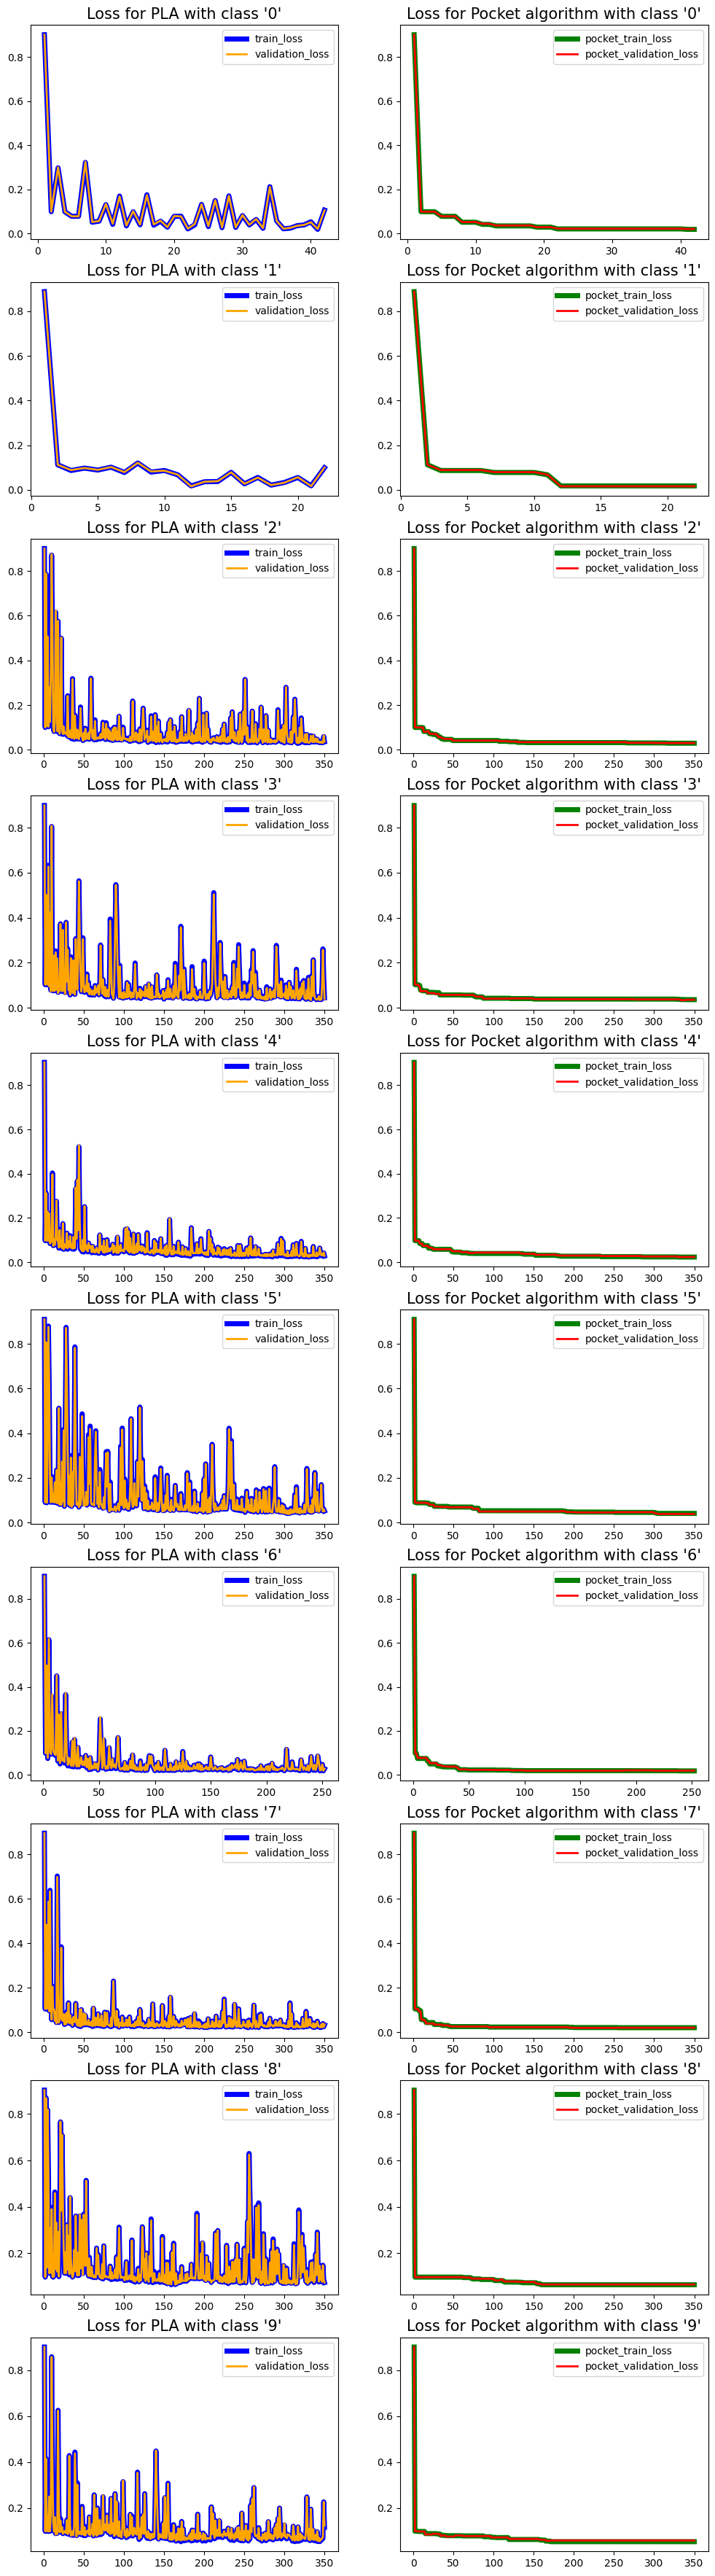

In [135]:
def perceptron_loss_graph(p, axs, i):
  # fetch history
  history = p.history.dropna()
  t = history['epoch']
  tl = history['train_loss']
  vl = history['validation_loss']
  ptl = history['pocket_train_loss']
  pvl = history['pocket_validation_loss']

  # data for plot
  font_size = 15
  clas = np.argmax(p.clas)

  # plot PLA loss
  axs[i, 0].plot(t, tl, 'b', lw=5, label=history.columns[1])
  axs[i, 0].plot(t, vl, 'orange', lw=2 ,label=history.columns[3])
  axs[i, 0].set_title(f"Loss for PLA with class '{clas}'",  fontsize=font_size)
  axs[i, 0].legend()

  # plot Pocket algorithm loss
  axs[i, 1].plot(t, ptl, 'g', lw=5, label=history.columns[2])
  axs[i, 1].plot(t, pvl, 'r', lw=2, label=history.columns[4])
  axs[i, 1].set_title(
      f"Loss for Pocket algorithm with class '{clas}'",  fontsize=font_size)
  axs[i, 1].legend()

# create graph
fig = plt.figure(figsize=(12, 45))
axs = fig.subplots(nrows=n_classes, ncols=2)

# create each row of the full graph for each perceptron
for i, perceptron in enumerate(mcp.perceptrons):
  perceptron_loss_graph(perceptron, axs, i)

plt.show()

#### Scoring the Multi-Class Perceptron

Let's score the test set to see how the model will do.

In [ ]:
# score test set
mcp_score = mcp.score(X_test, y_test)

Similarly, I'll next plot the confusion matrix for all the classes and their prediction rates.

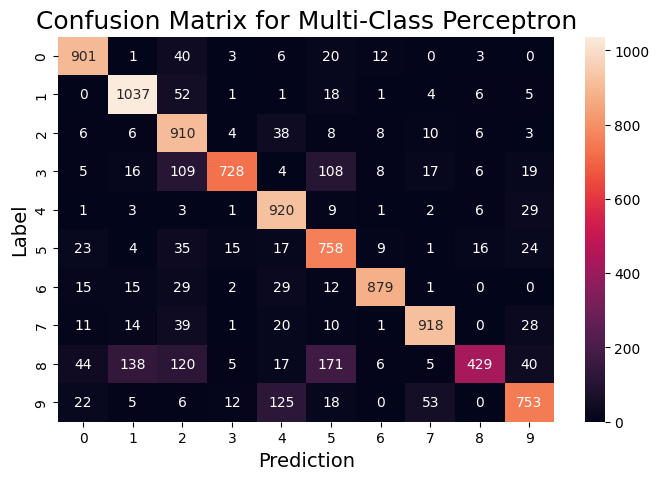

In [136]:
# fetch and arrange data to present in heatmap
header = mcp_score.assessment.index[:-1]
heatmap_df = pd.DataFrame(
  mcp_score.confusion_matrix, index=header, columns=header)

# plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Multi-Class Perceptron', fontsize=18)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Label', fontsize=14)

plt.show()

Lastly the accuracy, sensitivity and selectivity of each perceptron, with an avg representing the assessment of the Multi-Class Perceptron itself as a whole, will be given in a table.

In [143]:
headers = mcp_score.assessment.columns
table = tabulate(
  mcp_score.assessment, headers=headers, tablefmt="grid")
print(table)

+-----+------------+---------------+---------------+
|     |   accuracy |   sensitivity |   selectivity |
+=====+============+===============+===============+
| 0   |     0.979  |        0.914  |        0.986  |
+-----+------------+---------------+---------------+
| 1   |     0.971  |        0.922  |        0.977  |
+-----+------------+---------------+---------------+
| 2   |     0.948  |        0.911  |        0.952  |
+-----+------------+---------------+---------------+
| 3   |     0.966  |        0.714  |        0.995  |
+-----+------------+---------------+---------------+
| 4   |     0.969  |        0.944  |        0.972  |
+-----+------------+---------------+---------------+
| 5   |     0.948  |        0.84   |        0.959  |
+-----+------------+---------------+---------------+
| 6   |     0.985  |        0.895  |        0.995  |
+-----+------------+---------------+---------------+
| 7   |     0.978  |        0.881  |        0.99   |
+-----+------------+---------------+----------

## Conclusion

Looking over the loss graphs for each digit gives an interesting phenomenon, in the fittings i've done, with cut off enabled, the perceptrons training for '0' and '1' tend to finish much faster, and have much fewer mislabels in the confusion matrix, than say classifiers like the perceptron for '8', '9' and '3' which didn't cut off (they finished after all epochs as intended), with a much lower sensitivity of 0.714 for '9', 0.714 for '3' and whopping 0.44 for '8'! (per my last fitting). It seems '8' had the roughest job, routinely being confused for other digits. The aforemnetioned fitting has pretty good performance overall, with an average accuracy of 96%, average sensitivity of 82% and average selectivity of 98%, which are good results for a non linearly separable dataset with an elemantary algorithm such as the perceptron.

As sensitivity is computed proportional to the True Positives, it was the best assessor in this case for me to measure the actual preformance of the model and each of its' individual perceptrons, as each class is 'overpowered' by the rest of the classes in the case of binary classification. For example if we had a uniform distribution of classes, i.e. a 1 to 9 ratio, than even for a perceptron that mistags everything as "not class", it will have a 90% accuracy rate! but ofcourse that's meaningless to us, and it will have a sensitivity of 0% which is much more telling of the model.

Considering the deliberation above, I sould consider the model pretty effective in distinguising digits on the whole, with some glaring discrepancies between easily identifiable digits and those that are less so.

-- Roman Waitzman - 313597270